# kNN
提取样本中最相似的特征数据进行分类，选择前k个最相似的数据。
通常k是不大于20的整数，最后选择k个最相似数据中出现次数最多的分类，作为新数据的分类。

算法一般流程：
1. 收集数据
2. 准备数据：最好是结构化的数据格式
3. 分析数据
4. 计算错误率
5. 预测

## 1. 准备：使用python导入数据

In [1]:
import numpy as np
from collections import Counter

In [19]:
def createDataSet():
    group = np.array([[1.0, 1.1], [1.0, 1.0], [0.0, 0.0], [0.0, 0.1]])
    labels = np.array(['A', 'A', 'B', 'B'])
    return group, labels

In [20]:
group, labels = createDataSet()

In [21]:
group

array([[ 1. ,  1.1],
       [ 1. ,  1. ],
       [ 0. ,  0. ],
       [ 0. ,  0.1]])

In [22]:
labels

array(['A', 'A', 'B', 'B'],
      dtype='|S1')

## 2. 实施kNN分类算法

伪代码：
1. 计算已知类别数据集中的点与当前点的距离
2. 将距离递增排序
3. 选取最小的k个点
4. 找到k个点所在类别点概率，选取最高概率作为分类结果

In [40]:
def classify0(inX, dataSet, labels, k):
    m = dataSet.shape[0]
    dis = np.linalg.norm(inX - dataSet, axis = 1, ord = 2)
    indices = dis.argsort()
    voteLabels = []
    for i in range(k):
        voteLabels.append(labels[indices[i]])
    cnt = Counter(voteLabels)
    return cnt.most_common(1)[0][0]

In [41]:
classify0([0, 1], group, labels, 3)

'B'

## 3. 示例：约会网站配对效果

约会网站上的人可分为3种：
* 不喜欢的人
* 魅力一般的人
* 极具魅力的人
---
为了可以将人进行分类，现在收集一些样本，并采集以下3种__特征__:
* 每年获得的飞行常客里程数
* 玩视频游戏所耗时间百分比
* 每周消费的冰激凌公升数

### 3.1 收集数据

In [27]:
def File2Matrix(Filename):
    with open(Filename) as f:
        lines = f.readlines()
        rowNum = len(lines)
        firstRow = lines[0].strip()
        colNum = len(firstRow.split('\t'))
        X = np.zeros([rowNum, colNum - 1])
        Y = np.zeros([rowNum, 1])
        for row, line in enumerate(lines):
            line = line.strip()
            element = line.split('\t')
            X[row, :] = element[:-1]
            Y[row, 0] = element[-1]
            
        return X, Y

In [28]:
D, Y = File2Matrix('datingTestSet2.txt')

### 3.2 初步分析数据

使用matplotlib进行数据直观表述

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

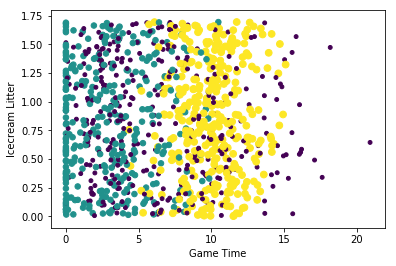

In [30]:
plt.scatter(D[:, 1], D[:, 2], 15*Y, 15*Y)
plt.xlabel('Game Time')
plt.ylabel('Icecream Litter')

### 3.3 归一化数据

In [31]:
D.shape

(1000, 3)

In [54]:
def Normalize(DataSet):
    minVals = DataSet.min(axis=0)
    maxVals = DataSet.max(axis=0)
    ranges = maxVals - minVals
    NormData = DataSet - minVals
    NormData = np.divide(NormData, ranges)
    return NormData, ranges, minVals
    

In [55]:
Normalize(D)

(array([[ 0.44832535,  0.39805139,  0.56233353],
        [ 0.15873259,  0.34195467,  0.98724416],
        [ 0.28542943,  0.06892523,  0.47449629],
        ..., 
        [ 0.29115949,  0.50910294,  0.51079493],
        [ 0.52711097,  0.43665451,  0.4290048 ],
        [ 0.47940793,  0.3768091 ,  0.78571804]]),
 array([  9.12730000e+04,   2.09193490e+01,   1.69436100e+00]),
 array([ 0.      ,  0.      ,  0.001156]))

### 3.4 测试算法

将样本划分成两部分，训练集和测试集，分别占90%和10%

In [60]:
def DatingClassTest(Ratio):
    totalX, totalY = File2Matrix('datingTestSet2.txt')
    normTotalX, _, _ = Normalize(totalX)
    m = normTotalX.shape[0]
    # train: 90%, test: 10%  
    testStartIndex = int(m * (1 - Ratio))
    trainX = normTotalX[0:testStartIndex, :]
    trainY = totalY[0:testStartIndex, :]
    testX = normTotalX[testStartIndex:, :]
    testY = totalY[testStartIndex:, :]
    error = 0.0
    for i in range(testX.shape[0]):
        result = classify0(testX[i, :], trainX, trainY.flatten(), 3)        
        if (result != testY[i]):
            error += 1
            print 'The classifier came back with: %d, the real answer is: %d' % (result, testY[i])
    print 'Total error count is %d, rate is %.4f' % (error, error / float(testX.shape[0]))

In [61]:
DatingClassTest(0.3)

The classifier came back with: 1, the real answer is: 2
The classifier came back with: 2, the real answer is: 1
The classifier came back with: 1, the real answer is: 2
The classifier came back with: 3, the real answer is: 2
The classifier came back with: 1, the real answer is: 3
The classifier came back with: 2, the real answer is: 3
The classifier came back with: 1, the real answer is: 3
The classifier came back with: 1, the real answer is: 2
The classifier came back with: 2, the real answer is: 3
The classifier came back with: 3, the real answer is: 2
The classifier came back with: 3, the real answer is: 2
Total error count is 11, rate is 0.0367


按照3:7划分数据得到的错误率是3.7%

### 3.5 实际预测

In [68]:
def Predict():
    labels = ['不够吸引', '一般', '特别有魅力']
    percentTats = float(raw_input('玩游戏的时间占用比例：'))
    ffMiles = float(raw_input('每年飞行里程数：'))
    iceCream = float(raw_input('每年消费冰激淋公升数：'))
    totalX, totalY = File2Matrix('datingTestSet2.txt')
    normTotalX, ranges, minVals = Normalize(totalX)
    inX = np.array([ffMiles, percentTats, iceCream])
    result = classify0((inX - minVals) / ranges, normTotalX, totalY.flatten(), 3)
    print '有可能遇到的人是：%s' % labels[int(result - 1)]

In [69]:
Predict()

玩游戏的时间占用比例：10
每年飞行里程数：10000
每年消费冰激淋公升数：0.5
有可能遇到的人是：一般


## 4. 手写识别系统

识别数字0-9，已经经过图像处理，每个数字都是相同的色彩和大小，宽和高是32\*32像素

### 4.1 准备数据：将图像转换成测试向量

将32\*32的矩阵转化成一个1\*1024的向量，下面将实现一个转换文本为向量的方法

In [103]:
def Img2Vec(filename):
    Vec = np.zeros([32, 32])
    with open(filename) as f:
        total = f.readlines()
        for row, col in enumerate(total):
            Vec[row, :] = np.r_[list(col.strip())]
    return Vec.reshape([1, 1024])

In [108]:
D = Img2Vec('digits/trainingDigits/3_106.txt')

### 4.2 测试算法

In [128]:
from os import listdir
def HandWritingTest():
    ## get training data
    trainingFiles = listdir('digits/trainingDigits/')
    m = len(trainingFiles)
    trainX = np.zeros([m, 1024])
    trainY = np.zeros([m, 1])
    for i, f in enumerate(trainingFiles):
        trainX[i, :] = Img2Vec('digits/trainingDigits/' + f)
        tempY = int(f.split('.')[0].split('_')[0])
        trainY[i, :] = tempY
    
    ## get test data
    testFiles = listdir('digits/testDigits/')
    error = 0.0
    for f in testFiles:
        testX = Img2Vec('digits/testDigits/' + f)
        testY = classify0(testX, trainX, trainY.flatten(), 3)
        testLabel = int(f.split('.')[0].split('_')[0])
        if (testY != testLabel):
            error += 1
            print 'The classifier came back with: %d, the real answer is: %d' % (testY, testLabel)
    print 'Total error count is %d, rate is %.4f' % (error, error / len(testFiles))

In [129]:
HandWritingTest()

The classifier came back with: 1, the real answer is: 8
The classifier came back with: 3, the real answer is: 8
The classifier came back with: 7, the real answer is: 9
The classifier came back with: 9, the real answer is: 3
The classifier came back with: 1, the real answer is: 8
The classifier came back with: 1, the real answer is: 9
The classifier came back with: 1, the real answer is: 8
The classifier came back with: 9, the real answer is: 3
The classifier came back with: 7, the real answer is: 1
The classifier came back with: 6, the real answer is: 5
The classifier came back with: 3, the real answer is: 5
The classifier came back with: 6, the real answer is: 8
Total error count is 12, rate is 0.0127
